**1. Get current DAX constituents from wikipedia**

In [187]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import time
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
#import copy

In [217]:
def dax40_latest_constituents():
    
    """
    Retrieves a dataframe of company name, ticker and sector of DAX40 index constituents from the website https://en.wikipedia.org/wiki/DAX.

    Args:
        None

    Returns:
        dataframe: A pandas dataframe of DAX40 with columns: Tickers, Name and Sector
    """

    url = 'https://en.wikipedia.org/wiki/DAX'
    response = requests.get(url)

    #Check if the connection is succesful
    try:
        response = requests.get(url)
        if response.ok:
            soup = BeautifulSoup(response.text, 'html.parser')
        else:
            raise Exception(f'Cannot reach website {url}')
    except:
        raise Exception(f'Website {url} does not exist')

    #check if table 'constituents' exists
    wiki_table_id = 'constituents'
    try:
        indiatable = soup.find('table',{'id': wiki_table_id,'class':'wikitable'})
        df = pd.read_html(str(indiatable))
    except:
        raise Exception(f'Table {wiki_table_id} cannot be found in {url}')

    #Extract columns from table
    extract_cols = ['Ticker', 'Company', 'Prime Standard Sector']
    try:
        dax_constituents = pd.DataFrame(df[0])[extract_cols]
        dax_constituents = dax_constituents.rename(columns = {'Prime Standard Sector': 'Sector', 'Company': 'Name'})
    except KeyError as e:
        raise Exception((e.args[0]).replace('index', 'column index of table constituents'))

    return dax_constituents

In [218]:
# #Test
dax_comp = dax40_latest_constituents()
# print(dax_comp.head(5))

Analyse the table of constituents

In [17]:
# dax_comp.groupby(['Sector'])['Sector'].count().sort_values(ascending=False).plot.bar()

In [219]:
def replace_by_freq(dataframe, column_name, threshold, new_value):

    """
    Replaces values in a column if the frequency of values is less than a threshold

    Args:
        dataframe: A dataframe to be modified
        column_name (str): A column name in dataframe where the replacement will be done
        threshold (int): A cutoff, if any values occur less than a thresshold value they are replaced
        new_value (Union[str, int, float]): A value to be replaced with
    
    Returns:
        dataframe: a dataframe with modified values
    """

    try:
        unique = dataframe.groupby(column_name)[column_name].transform('size').lt(threshold)
        dataframe.loc[unique, column_name] = new_value
    except KeyError as ke:
        print(f'Column ', ke, 'is not found in a dataframe')

        #raise Exception(f'Could not replace values in column {column_name} in dataframe {dataframe}')
    
    return dataframe

In [221]:
dax_comp_replaced = replace_by_freq(dax_comp, 'Sector', 2, 'Other')

In [223]:
#print(dax_comp_replaced)

In [21]:
# dax_comp_replaced.groupby(['Sector'])['Sector'].count().sort_values(ascending=False).plot.bar()

In [224]:
#A list of tickers from contituents
dax_tickers = dax_comp_replaced['Ticker'].values.tolist()

In [23]:
# len(dax_tickers)

In [24]:
# dax_tickers[:5]

Download monthly data from yahoo API

In [225]:
def get_stock_price(ticker, start_date = "2001-04-01", end_date = "2023-01-01", price_interval = '1mo'):

    """
    Returns a pandas series of closed prices from yfinance

    Args:
        ticker (str): A stock identifier in yahoo finance
        start_date (date): Begin of the series
        end_date (date): End of the series
        granularity (str): Frequency of the presented series

    Returns:
        pandas series: a time series of closed prices with timestamp as an index
    """
    interval_types = ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

    if price_interval not in interval_types:
        raise ValueError(f'Unknown interval type: {price_interval}. Acceptable arguments are {interval_types}')
    

    stock_data = yf.Ticker(ticker)
    stock_series = stock_data.history(start = start_date, end = end_date, interval = price_interval).Close

    if stock_series.empty:
        raise ValueError(f'{ticker} either does not exist or does not have data for a given time period')

    return stock_series


In [69]:
dax_tickers_sample = ['ADS.DE', 'AIR.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', '1COV.DE']

In [226]:
def get_data(tickers):

    """
    Returns a pandas dataframe with named columns of Close prices from yfinance

    Args:
        tickers (str, List of strings): A stock identifiers in yahoo finance

    Returns:
        pandas dataframe: a time series of closed prices with timestamp as an index and ticker names as columns
    """

    output = {}

    with tqdm(total = len(tickers)) as pbar:
        for one_ticker in tickers:
            pbar.set_postfix_str(one_ticker)
            try:
                stock_price = get_stock_price(ticker = one_ticker)
                output[one_ticker] = stock_price
            except ValueError as e:
                print(e) #substitute with logging
                pass
            pbar.update()
            time.sleep(0.5)
            
    
    return pd.DataFrame(output)

In [71]:
#Create function which deletes columns it at least one null

In [227]:
dax_data = get_data(tickers = dax_tickers)

100%|██████████| 40/40 [00:33<00:00,  1.19it/s, ZAL.DE] 


In [216]:
def convert_datetime_index_to_date(df):
    """
    Returns a dataframe with index converted to date format

    Args:
        dataframe: A dataframe with datetime index format

    Returns:
        dataframe: A dataframe with date index format
    
    """
    try:
        df.index = pd.to_datetime(df.index.date)
    except AttributeError as e:
        raise Exception(f'Could not convert index of a dataframe to date. Error message: {e}')
    return df

In [228]:
dax_data = convert_datetime_index_to_date(dax_data)

In [229]:
dax_data.head(5)

,ADS.DE,AIR.DE,ALV.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE,BNR.DE,CBK.DE,CON.DE,...,RWE.DE,SAP.DE,SRT3.DE,SIE.DE,ENR.DE,SHL.DE,SY1.DE,VOW3.DE,VNA.DE,ZAL.DE
2001-04-01,12.388227,11.366357,135.761948,8.786170,22.925451,26.336121,17.918510,NaN,197.825958,9.718940,...,17.911945,29.804974,1.006678,41.608429,NaN,NaN,NaN,12.966839,NaN,NaN
2001-05-01,12.688920,12.779557,138.146683,8.732551,23.212965,25.446083,19.216879,NaN,183.437531,9.814931,...,17.993361,26.641314,1.014796,42.358418,NaN,NaN,NaN,14.101770,NaN,NaN
2001-06-01,13.288910,12.542808,144.234009,8.567093,23.043926,28.184677,18.949821,NaN,187.359497,10.000916,...,19.125071,27.691151,1.071625,36.248638,NaN,NaN,NaN,13.720947,NaN,NaN
2001-07-01,14.177775,12.797054,134.293457,8.548710,23.491385,31.013151,19.623487,NaN,163.916061,9.481709,...,20.410051,28.028852,0.986490,32.173786,NaN,NaN,NaN,13.822634,NaN,NaN
2001-08-01,13.692941,10.621838,129.579971,8.272943,17.575039,30.511534,17.035454,NaN,171.249969,8.999586,...,19.257902,25.057114,1.045511,28.028950,NaN,NaN,NaN,12.365980,NaN,NaN


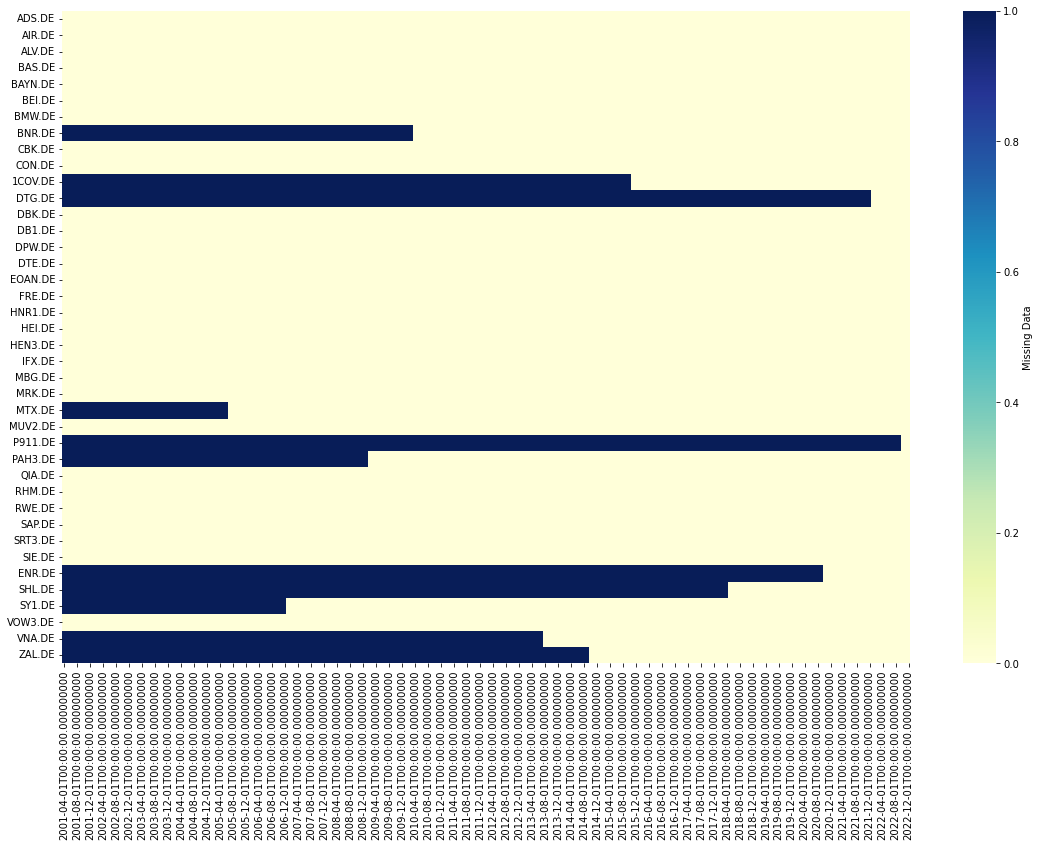

In [211]:
plt.figure(figsize=(19,12))
sns.heatmap(dax_data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("dax40_missing_values.png", dpi=100)

In [230]:
def drop_columns_with_na(df):

    """
    Eliminates columns with ath least one NA value

    Args:
        pandas dataframe: dataframe to be cleaned

    Returns:
        pandas dataframe: dataframe with no NA values

    """

    # Check for NA values in each column
    columns_contain_na = df.columns[df.isnull().any()].tolist()
    
    # Drop columns with NA values
    df_dropped = df.drop(columns=columns_contain_na)
    
    return df_dropped

In [231]:
dax_data_clean = drop_columns_with_na(dax_data)

<AxesSubplot:>

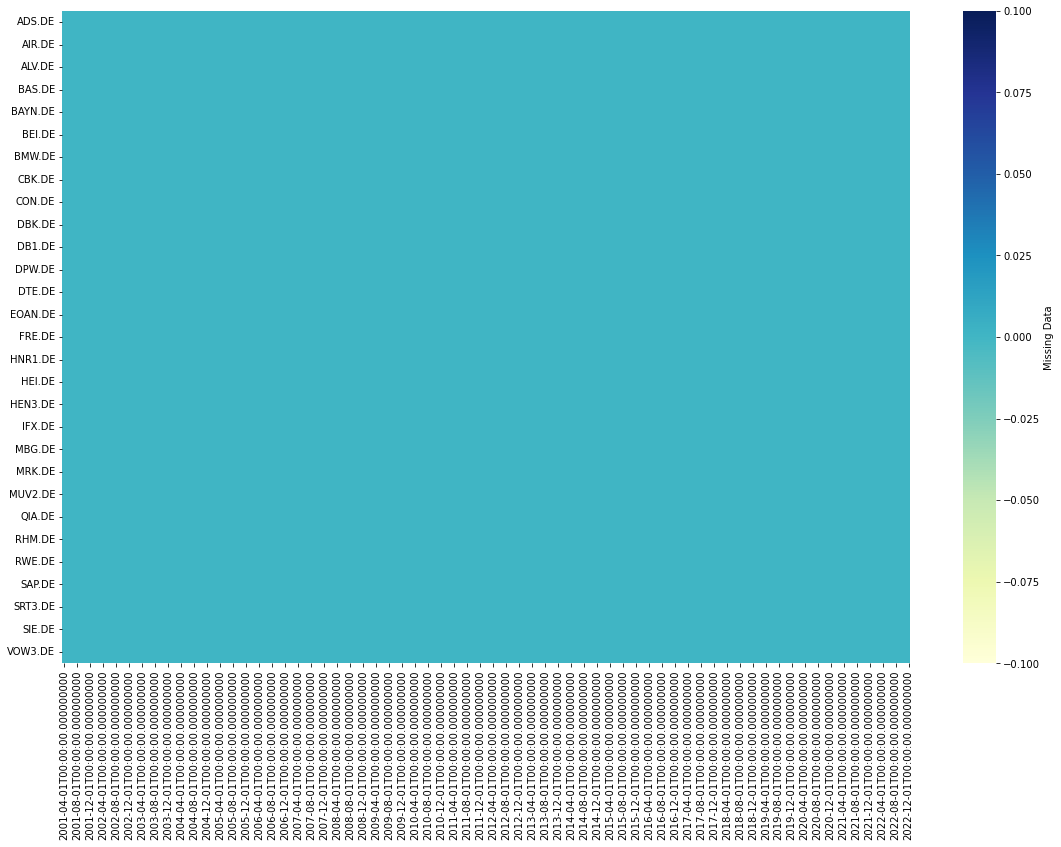

In [232]:
plt.figure(figsize=(19,12))
sns.heatmap(dax_data_clean.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
#plt.savefig("dax40_missing_values.png", dpi=100)

In [ ]:
#Chat GPT

# import pandas as pd
# import logging

# def drop_columns_with_na(df):
#     # Create a logger
#     logger = logging.getLogger(__name__)
#     logger.setLevel(logging.INFO)
    
#     # Check for NA values in each column
#     columns_with_na = df.columns[df.isna().any()].tolist()
    
#     # Drop columns with NA values
#     df_dropped = df.drop(columns=columns_with_na)
    
#     # Log dropped columns
#     logger.info("Dropped columns: %s", ", ".join(columns_with_na))
    
#     return df_dropped

In [75]:
#Function to retrieve data:
#ok Input list of tickers 
#check it they are strings and is a list
#ok Checks if ticker can be downloaded (is in yahoo finance) 
#ok appends list with data
#ok appends list with ticker name
#retrieves data with 1s time postponment
#if some stocks have nulls -> delete them
#returns a dataframe
#creates logs what tickers have been downloaded
#at least two time series should be to do mvp